<a href="https://colab.research.google.com/github/jurader/2PL-MDNRM/blob/main/04_2PL_MDNRMb_gamma_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDNRMb with gamma distribution


In [ ]:
! pip install -q numpyro==0.10.1 watermark==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az
import jax.numpy as jnp

In [ ]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(8)

## Import & Check Data

In [ ]:
! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/nrm_ground_truth_and_results.csv -O ground_truth_and_results.csv

--2024-02-25 23:42:50--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/nrm_ground_truth_and_results.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2272 (2.2K) [text/csv]
Saving to: ‘ground_truth_and_results.csv’

ground_truth_and_re 100%[===================>]   2.22K  --.-KB/s    in 0s      

2024-02-25 23:42:51 (1.04 GB/s) - ‘ground_truth_and_results.csv’ saved [2272/2272]



In [ ]:
df = pd.read_csv('./ground_truth_and_results.csv')

In [ ]:
df.head()

,GT,MN,YU,EN,HM,DK,YW
0,1,1,0,1,1,1,1
1,1,1,1,1,1,1,0
2,0,1,0,0,0,0,0
3,1,1,1,2,2,2,2
4,1,1,1,1,1,2,2


In [ ]:
df = df + 1


In [ ]:
df.head()

,GT,MN,YU,EN,HM,DK,YW
0,2,2,1,2,2,2,2
1,2,2,2,2,2,2,1
2,1,2,1,1,1,1,1
3,2,2,2,3,3,3,3
4,2,2,2,2,2,3,3


In [ ]:
df.describe()

,GT,MN,YU,EN,HM,DK,YW
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.000000,1.993333,2.026667,2.000000,1.766667,1.973333,1.606667
std,0.819232,0.823291,0.818795,0.819232,0.870213,0.826951,0.818385
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [ ]:
print( 0, (df["GT"]==0).sum() )
print( 1, (df["GT"]==1).sum() )
print( 2, (df["GT"]==2).sum() )
print( 3, (df["GT"]==2).sum() )

# 1 -> normal
# 2 -> non-COVID19 pneumonia
# 3 -> COVID19 pneumonia

0 0
1 50
2 50
3 50


## Convert Data

In [ ]:
num_classes = 3

In [ ]:
rad_resp = df.iloc[:,1:].copy()


In [ ]:
num_cases = rad_resp.shape[0]
num_doctors = rad_resp.shape[1]
gt_types = df["GT"]


In [ ]:
print(num_cases)
print(num_doctors)

150
6


In [ ]:
gt_types

0      2
1      2
2      1
3      2
4      2
      ..
145    2
146    2
147    3
148    3
149    3
Name: GT, Length: 150, dtype: int64

In [ ]:
rad_resp

,MN,YU,EN,HM,DK,YW
0,2,1,2,2,2,2
1,2,2,2,2,2,1
2,2,1,1,1,1,1
3,2,2,3,3,3,3
4,2,2,2,2,3,3
...,...,...,...,...,...,...
145,2,2,2,3,3,3
146,2,2,2,2,2,2
147,3,3,2,3,3,3
148,3,3,3,1,2,3


In [ ]:
num_classes = 3

In [ ]:
y = rad_resp.to_numpy() - 1
y_true = gt_types.to_numpy() - 1

In [ ]:
print(y.shape)
print(y_true.shape)

(150, 6)
(150,)


## Generate Index

In [ ]:
i_alpha = np.zeros((num_cases, num_doctors, num_classes), dtype=int)
#i_beta = np.zeros((num_cases, num_doctors, num_classes), dtype=int)

for i in range(num_cases):
    for j in range(num_doctors):
        for k in range(num_classes):
            i_alpha[i, j, k] = k
            #i_beta[i, j, k] = i

## Define Model

### Overview of Paramters

**theta**: radiologist's ability
- theta.shape: (number of classes) x (number of radiologists) x (number of classes)

**alpha**: item's discrimination
- alpha.shape: (number of classes)

**beta**: difficulty based on class
- beta.shape: (number of items) x (number of classes)


In [ ]:
theta_sd = 2
beta_sd = 2

In [ ]:
def model(y=None, y_true=None, i_beta=None, num_cases=0, num_doctors=0, num_classes=0):

    theta = numpyro.sample('theta', dist.Normal(0, theta_sd), sample_shape=(num_classes, num_doctors, num_classes))
    #alpha = numpyro.sample('alpha', dist.HalfNormal(10), sample_shape=(num_classes,))
    alpha = numpyro.sample('alpha', dist.Gamma(2, 2), sample_shape=(num_cases,))
    beta = numpyro.sample('beta', dist.Normal(0, beta_sd), sample_shape=(num_cases, 1, num_classes))

    beta_tiled = jnp.tile(beta, (1, num_doctors, 1))

    # logits.shape : (num_cases, num_doctors, num_classes)
    logits = theta[y_true, :, :] * alpha[i_alpha] + beta_tiled

    numpyro.sample('obs', dist.Categorical(logits=logits), obs=y)

## Inference

In [ ]:
nuts = numpyro.infer.NUTS(model)

In [ ]:
%%time

mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=8000, num_chains=8)

mcmc.run(jax.random.PRNGKey(0), y=y, y_true=y_true, i_beta=i_beta, num_cases=num_cases, num_doctors=num_doctors, num_classes=num_classes)
mcmc_samples = mcmc.get_samples()

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

CPU times: user 3min 23s, sys: 751 ms, total: 3min 24s
Wall time: 2min 3s


## Evaluate Results

In [ ]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


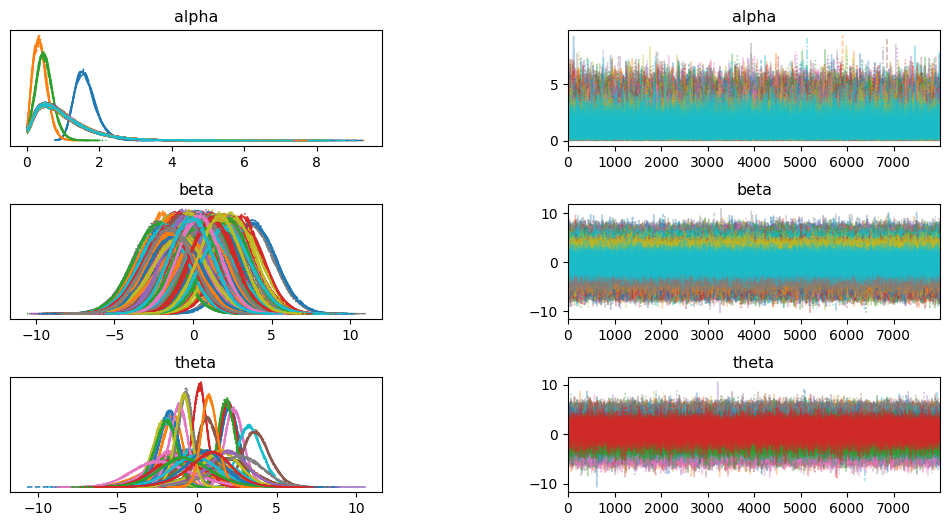

In [ ]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
az.summary(idata, var_names=['theta'])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[0, 0, 0]",2.140,0.596,1.082,3.294,0.004,0.003,21392.0,34114.0,1.0
"theta[0, 0, 1]",0.592,1.754,-2.675,3.973,0.008,0.006,46007.0,44214.0,1.0
"theta[0, 0, 2]",-1.365,1.606,-4.389,1.721,0.008,0.006,43682.0,38166.0,1.0
"theta[0, 1, 0]",2.022,0.566,0.980,3.096,0.004,0.003,24693.0,34578.0,1.0
"theta[0, 1, 1]",-0.431,1.704,-3.670,2.773,0.007,0.006,52219.0,45268.0,1.0
"theta[0, 1, 2]",-0.034,1.535,-2.938,2.907,0.007,0.006,51208.0,44570.0,1.0
"theta[0, 2, 0]",2.384,0.610,1.266,3.541,0.004,0.003,24920.0,34985.0,1.0
"theta[0, 2, 1]",-0.212,1.731,-3.495,3.063,0.007,0.007,60562.0,47825.0,1.0
"theta[0, 2, 2]",-0.413,1.590,-3.333,2.717,0.007,0.006,56174.0,45625.0,1.0
"theta[0, 3, 0]",3.389,0.773,2.000,4.875,0.005,0.004,24140.0,38565.0,1.0


## Evaluate Rhat

Evaluate whether the Rhat values of all parameters were less than 1.10.

In [ ]:
df = az.summary(idata)

In [ ]:
df['r_hat']

alpha[0]          1.0
alpha[1]          1.0
alpha[2]          1.0
alpha[3]          1.0
alpha[4]          1.0
                 ... 
theta[2, 4, 1]    1.0
theta[2, 4, 2]    1.0
theta[2, 5, 0]    1.0
theta[2, 5, 1]    1.0
theta[2, 5, 2]    1.0
Name: r_hat, Length: 654, dtype: float64

In [ ]:
np.count_nonzero(df['r_hat'] > 1.1)

0

## Evaluate Theta

In [ ]:
# Doctor's ids to compare
idA = 1
idB = 5

In [ ]:
theta = idata.posterior['theta'].to_numpy()
theta = theta.swapaxes(2, 3)
theta.shape

(8, 8000, 6, 3, 3)

In [ ]:
theta_idA = theta[:, :, idA, 2, 2]
theta_idB = theta[:, :, idB, 2, 2]

print(theta_idA.shape)
print(theta_idB.shape)

(8, 8000)
(8, 8000)


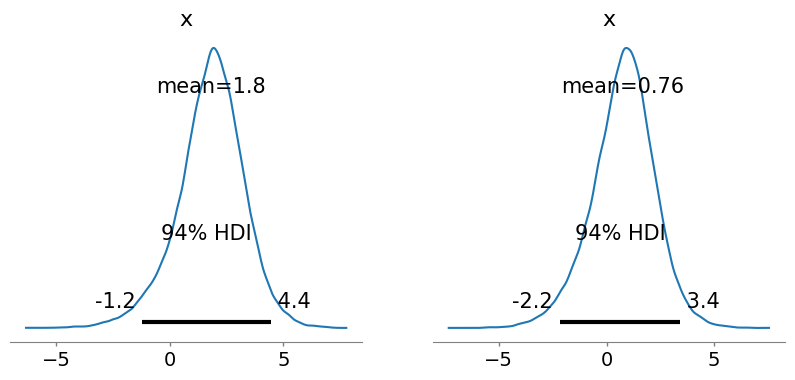

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

az.plot_posterior(theta_idA, ax=axes[0])
az.plot_posterior(theta_idB, ax=axes[1])

plt.show()

In [ ]:
d = theta_idA - theta_idB

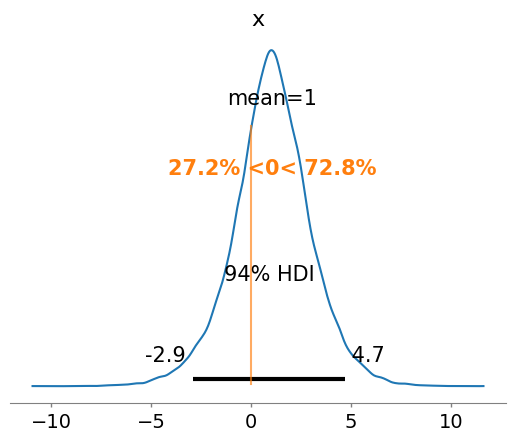

In [ ]:
az.plot_posterior(d, ref_val=0)
plt.show()

## Calculate WAIC and LOO

In [ ]:
az.waic(idata, scale='deviance')

<ipython-input-38-aa33c236106c>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(idata, scale='deviance')
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 64000 posterior samples and 900 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  1144.81    47.56
p_waic          185.37        -

There has been a warning during the calculation. Please check the results.

In [ ]:
az.loo(idata, scale='deviance')

<ipython-input-39-f6188337fe90>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.loo(idata, scale='deviance')
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 64000 posterior samples and 900 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  1174.15    49.28
p_loo          200.04        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      845   93.9%
 (0.5, 0.7]   (ok)         53    5.9%
   (0.7, 1]   (bad)         2    0.2%
   (1, Inf)   (very bad)    0    0.0%

## Export Inference Data

In [ ]:
az.to_netcdf(idata, 'idata_md_nrm_extended_weakprior.nc')

'idata_md_nrm_extended_weakprior.nc'

## Environment

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Feb 25 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpyro   : 0.10.1
numpy     : 1.25.2
matplotlib: 3.7.1
pandas    : 1.5.3
seaborn   : 0.13.1
arviz     : 0.15.1
jax       : 0.4.23

Watermark: 2.3.1

